# NSE Stock Closing Price Predictions

This project involved making use of time series models to predict the stock closing prices of APOLLOHOSP, TITAN and ASIANPAINT stocks in NSE on 20th October, 2023, as part of an assignment in our Data Analytics university course. \\

We were supposed to use the stock data from the official NSE site (dated between 17th October 2022 and 17th October 2023) in order to predict the closing price on 20th (18th and 19th were Saturday and Sunday respectively).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Helper Functions

The dataset contained dates in a string format. So I had to write a function to convert these strings to `datetime` objects. \\

Apart from that, a trivial function to remove commas from a string.

In [ ]:
import datetime

def string_to_datetime(s):
    months = {"Jan" : 1,
          "Feb" : 2,
          "Mar" : 3,
          "Apr" : 4,
          "May" : 5,
          "Jun" : 6,
          "Jul" : 7,
          "Aug" : 8,
          "Sep" : 9,
          "Oct" : 10,
          "Nov" : 11,
          "Dec" : 12}

    s = s.split("-")

    day, month, year = int(s[0]), months[s[1]], int(s[2])

    return datetime.datetime(year = year, month = month, day = day)


def remove_comma(s):
    s = s.replace(',', '')

    return s

# Feature Engineering

For all the datasets henceforth, I will be generating new features using the ones already in the dataset. This is to give the model better features, so that it can fit to the training set better. \\

In general, I have used a mix of the original variables like `OPEN`, `CLOSE`, `HIGH`, `LOW` and `VOLUME` and a bunch of other features derived from these original features. \\

These derived features include lag features and moving averages.

# Apollo Prediction

## Data Pre-Processing

First, some cleaning up and pre-processing of the dataset.

In [ ]:
apollo_df = pd.read_csv('apollo.csv')
apollo_df = apollo_df.iloc[::-1]

In [ ]:
apollo_df['Date '] = apollo_df['Date '].apply(string_to_datetime)

apollo_df['OPEN '] = apollo_df['OPEN '].apply(remove_comma).astype(float)
apollo_df['HIGH '] = apollo_df['HIGH '].apply(remove_comma).astype(float)
apollo_df['LOW '] = apollo_df['LOW '].apply(remove_comma).astype(float)
apollo_df['PREV. CLOSE '] = apollo_df['PREV. CLOSE '].apply(remove_comma).astype(float)
apollo_df['ltp '] = apollo_df['ltp '].apply(remove_comma).astype(float)
apollo_df['close '] = apollo_df['close '].apply(remove_comma).astype(float)
apollo_df['vwap '] = apollo_df['vwap '].apply(remove_comma).astype(float)
apollo_df['52W H '] = apollo_df['52W H '].apply(remove_comma).astype(float)
apollo_df['52W L '] = apollo_df['52W L '].apply(remove_comma).astype(float)
apollo_df['VOLUME '] = apollo_df['VOLUME '].apply(remove_comma).astype(float)
apollo_df['VALUE '] = apollo_df['VALUE '].apply(remove_comma).astype(float)

apollo_df.reset_index(inplace = True)
apollo_df.drop(columns = ['index'], inplace = True)

apollo_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2022-11-17,EQ,4490.00,4515.95,4370.70,4479.25,4400.05,4400.30,4417.12,5935.40,3361.55,430622.0,1.902108e+09,"33,966"
1,2022-11-18,EQ,4430.00,4449.00,4320.00,4400.30,4387.95,4399.15,4374.59,5935.40,3361.55,385705.0,1.687303e+09,"37,936"
2,2022-11-21,EQ,4403.95,4440.00,4341.00,4399.15,4404.05,4418.85,4397.57,5935.40,3361.55,336664.0,1.480505e+09,"30,724"
3,2022-11-22,EQ,4420.95,4480.00,4380.00,4418.85,4479.00,4469.80,4436.44,5935.40,3361.55,310657.0,1.378211e+09,"30,305"
4,2022-11-23,EQ,4482.30,4616.15,4448.00,4469.80,4610.00,4605.20,4564.53,5935.40,3361.55,799422.0,3.648982e+09,"66,636"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-12,EQ,5300.00,5300.00,5265.00,5278.50,5274.00,5275.55,5278.00,5364.00,4123.00,18707.0,9.873562e+07,"2,975"
246,2023-11-13,EQ,5250.00,5279.00,5200.20,5275.55,5223.00,5220.65,5227.28,5364.00,4123.00,150128.0,7.847613e+08,"19,113"
247,2023-11-15,EQ,5283.85,5295.00,5207.00,5220.65,5227.00,5224.95,5229.88,5364.00,4123.00,356675.0,1.865366e+09,"49,934"
248,2023-11-16,EQ,5224.00,5368.00,5201.75,5224.95,5332.20,5338.75,5305.38,5368.00,4123.00,449045.0,2.382356e+09,"60,107"


## A Note on Assumed Values of Exogenous Variables

Note that, in order to predict the `CLOSE` value on 20th, we had to make some assumptions about the possible values of the other variables on that day, like `OPEN` and `VOLUME`, since there was no direct way of knowing on the day before.

Some of the assumptions made (in general, across all 3 datasets) included:
- The `OPEN` price on 20th would be the previous `CLOSE` price.
- The `HIGH` and `LOW` columns were filled with the exponential moving average to ensure that the most recent days got greater weightage.
- The `VOLUME` column was filled with a simple moving average. \\

Another thing to note was that India had lost the cricket World Cup on the previous day (19th October). So, an assumption was made that the stock markets would be down due to investor sentiments. Accordingly, we made additions and subtractions to these assumed variables.

In [ ]:
apollo_df['Volume_ma5'] = apollo_df['VOLUME '].rolling(5).mean()
apollo_df['ltp_ma5'] = apollo_df['ltp '].rolling(5).mean()

apollo_df['Low_ema'] = apollo_df['LOW '].ewm(com = 2.5).mean()
apollo_df['High_ema'] = apollo_df['HIGH '].ewm(com = 2.5).mean()

apollo_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,Volume_ma5,ltp_ma5,Low_ema,High_ema
0,2022-11-17,EQ,4490.00,4515.95,4370.70,4479.25,4400.05,4400.30,4417.12,5935.40,3361.55,430622.0,1.902108e+09,"33,966",NaN,NaN,4370.700000,4515.950000
1,2022-11-18,EQ,4430.00,4449.00,4320.00,4400.30,4387.95,4399.15,4374.59,5935.40,3361.55,385705.0,1.687303e+09,"37,936",NaN,NaN,4341.125000,4476.895833
2,2022-11-21,EQ,4403.95,4440.00,4341.00,4399.15,4404.05,4418.85,4397.57,5935.40,3361.55,336664.0,1.480505e+09,"30,724",NaN,NaN,4341.068807,4460.309633
3,2022-11-22,EQ,4420.95,4480.00,4380.00,4418.85,4479.00,4469.80,4436.44,5935.40,3361.55,310657.0,1.378211e+09,"30,305",NaN,NaN,4356.106419,4467.915259
4,2022-11-23,EQ,4482.30,4616.15,4448.00,4469.80,4610.00,4605.20,4564.53,5935.40,3361.55,799422.0,3.648982e+09,"66,636",452614.0,4456.21,4388.358500,4519.941514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-12,EQ,5300.00,5300.00,5265.00,5278.50,5274.00,5275.55,5278.00,5364.00,4123.00,18707.0,9.873562e+07,"2,975",474006.8,5217.37,5142.583268,5238.390976
246,2023-11-13,EQ,5250.00,5279.00,5200.20,5275.55,5223.00,5220.65,5227.28,5364.00,4123.00,150128.0,7.847613e+08,"19,113",459591.6,5234.97,5159.045191,5249.993555
247,2023-11-15,EQ,5283.85,5295.00,5207.00,5220.65,5227.00,5224.95,5229.88,5364.00,4123.00,356675.0,1.865366e+09,"49,934",450827.0,5257.16,5172.746565,5262.852539
248,2023-11-16,EQ,5224.00,5368.00,5201.75,5224.95,5332.20,5338.75,5305.38,5368.00,4123.00,449045.0,2.382356e+09,"60,107",334192.8,5263.60,5181.033261,5292.894671


In [ ]:
new_row = {'Date ': pd.to_datetime('2023-11-19'), 'OPEN ': apollo_df.iloc[249]['close '], 'VOLUME ': apollo_df.iloc[249]['Volume_ma5'], 'LOW ': apollo_df.iloc[249]['LOW '] + 200, 'HIGH ': apollo_df.iloc[249]['HIGH '] + 200, 'ltp ': apollo_df.iloc[249]['ltp '] + 200, 'close ': apollo_df.iloc[249]['close ']}
apollo_df.loc[len(apollo_df)] = new_row

apollo_df.drop(columns=['Volume_ma5', 'ltp_ma5', 'Low_ema', 'High_ema'], inplace = True)
apollo_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2022-11-17,EQ,4490.00,4515.95,4370.70,4479.25,4400.05,4400.30,4417.12,5935.40,3361.55,430622.0,1.902108e+09,"33,966"
1,2022-11-18,EQ,4430.00,4449.00,4320.00,4400.30,4387.95,4399.15,4374.59,5935.40,3361.55,385705.0,1.687303e+09,"37,936"
2,2022-11-21,EQ,4403.95,4440.00,4341.00,4399.15,4404.05,4418.85,4397.57,5935.40,3361.55,336664.0,1.480505e+09,"30,724"
3,2022-11-22,EQ,4420.95,4480.00,4380.00,4418.85,4479.00,4469.80,4436.44,5935.40,3361.55,310657.0,1.378211e+09,"30,305"
4,2022-11-23,EQ,4482.30,4616.15,4448.00,4469.80,4610.00,4605.20,4564.53,5935.40,3361.55,799422.0,3.648982e+09,"66,636"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2023-11-13,EQ,5250.00,5279.00,5200.20,5275.55,5223.00,5220.65,5227.28,5364.00,4123.00,150128.0,7.847613e+08,"19,113"
247,2023-11-15,EQ,5283.85,5295.00,5207.00,5220.65,5227.00,5224.95,5229.88,5364.00,4123.00,356675.0,1.865366e+09,"49,934"
248,2023-11-16,EQ,5224.00,5368.00,5201.75,5224.95,5332.20,5338.75,5305.38,5368.00,4123.00,449045.0,2.382356e+09,"60,107"
249,2023-11-17,EQ,5332.20,5493.35,5306.15,5338.75,5485.00,5478.95,5443.61,5493.35,4123.00,735541.0,4.004000e+09,"69,714"


In [ ]:
apollo_df.set_index('Date ', inplace = True)
apollo_df

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2022-11-17,EQ,4490.00,4515.95,4370.70,4479.25,4400.05,4400.30,4417.12,5935.40,3361.55,430622.0,1.902108e+09,"33,966"
2022-11-18,EQ,4430.00,4449.00,4320.00,4400.30,4387.95,4399.15,4374.59,5935.40,3361.55,385705.0,1.687303e+09,"37,936"
2022-11-21,EQ,4403.95,4440.00,4341.00,4399.15,4404.05,4418.85,4397.57,5935.40,3361.55,336664.0,1.480505e+09,"30,724"
2022-11-22,EQ,4420.95,4480.00,4380.00,4418.85,4479.00,4469.80,4436.44,5935.40,3361.55,310657.0,1.378211e+09,"30,305"
2022-11-23,EQ,4482.30,4616.15,4448.00,4469.80,4610.00,4605.20,4564.53,5935.40,3361.55,799422.0,3.648982e+09,"66,636"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,EQ,5250.00,5279.00,5200.20,5275.55,5223.00,5220.65,5227.28,5364.00,4123.00,150128.0,7.847613e+08,"19,113"
2023-11-15,EQ,5283.85,5295.00,5207.00,5220.65,5227.00,5224.95,5229.88,5364.00,4123.00,356675.0,1.865366e+09,"49,934"
2023-11-16,EQ,5224.00,5368.00,5201.75,5224.95,5332.20,5338.75,5305.38,5368.00,4123.00,449045.0,2.382356e+09,"60,107"


## Train-Val Split

The original dataset had 300 examples. We split it into the following two datasets:
- Train Set - 210 Examples
- Val Set - 40 Examples

In [ ]:
apollo_train = apollo_df[:210]
apollo_train

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2022-11-17,EQ,4490.00,4515.95,4370.70,4479.25,4400.05,4400.30,4417.12,5935.4,3361.55,430622.0,1.902108e+09,"33,966"
2022-11-18,EQ,4430.00,4449.00,4320.00,4400.30,4387.95,4399.15,4374.59,5935.4,3361.55,385705.0,1.687303e+09,"37,936"
2022-11-21,EQ,4403.95,4440.00,4341.00,4399.15,4404.05,4418.85,4397.57,5935.4,3361.55,336664.0,1.480505e+09,"30,724"
2022-11-22,EQ,4420.95,4480.00,4380.00,4418.85,4479.00,4469.80,4436.44,5935.4,3361.55,310657.0,1.378211e+09,"30,305"
2022-11-23,EQ,4482.30,4616.15,4448.00,4469.80,4610.00,4605.20,4564.53,5935.4,3361.55,799422.0,3.648982e+09,"66,636"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,EQ,4975.00,5021.20,4945.00,4979.20,5021.20,5011.00,4994.82,5364.0,4123.00,232238.0,1.159986e+09,"28,528"
2023-09-14,EQ,5001.00,5100.00,4995.50,5011.00,5086.05,5084.55,5070.64,5364.0,4123.00,414391.0,2.101227e+09,"48,918"
2023-09-15,EQ,5084.55,5150.40,5061.70,5084.55,5100.00,5091.80,5107.56,5364.0,4123.00,658355.0,3.362586e+09,"44,838"


In [ ]:
apollo_val = apollo_df[-40:]
apollo_val

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2023-09-22,EQ,5013.00,5016.80,4955.00,5020.05,4999.20,4989.55,4989.37,5364.00,4123.0,348459.0,1.738589e+09,"26,733"
2023-09-25,EQ,5014.90,5113.45,4972.85,4989.55,5087.20,5097.05,5064.45,5364.00,4123.0,386746.0,1.958655e+09,"39,115"
2023-09-26,EQ,5097.00,5097.00,5030.25,5097.05,5050.00,5053.70,5061.87,5364.00,4123.0,267102.0,1.352037e+09,"44,448"
2023-09-27,EQ,5054.00,5118.85,5020.00,5053.70,5105.00,5105.35,5087.49,5364.00,4123.0,460768.0,2.344151e+09,"42,762"
2023-09-28,EQ,5105.35,5145.50,4995.00,5105.35,5037.05,5020.10,5079.46,5364.00,4123.0,407714.0,2.070966e+09,"44,227"
2023-09-29,EQ,5054.00,5186.95,5026.60,5020.10,5144.95,5137.75,5137.95,5364.00,4123.0,410567.0,2.109474e+09,"40,082"
2023-10-03,EQ,5138.95,5154.95,5066.00,5137.75,5111.00,5118.95,5117.89,5364.00,4123.0,268482.0,1.374060e+09,"42,505"
2023-10-04,EQ,5085.00,5096.85,4982.30,5118.95,5048.20,5047.40,5037.27,5364.00,4123.0,442482.0,2.228903e+09,"53,537"
2023-10-05,EQ,5054.95,5079.85,5026.65,5047.40,5040.50,5047.05,5054.27,5364.00,4123.0,363289.0,1.836161e+09,"46,044"


<Axes: xlabel='Date '>

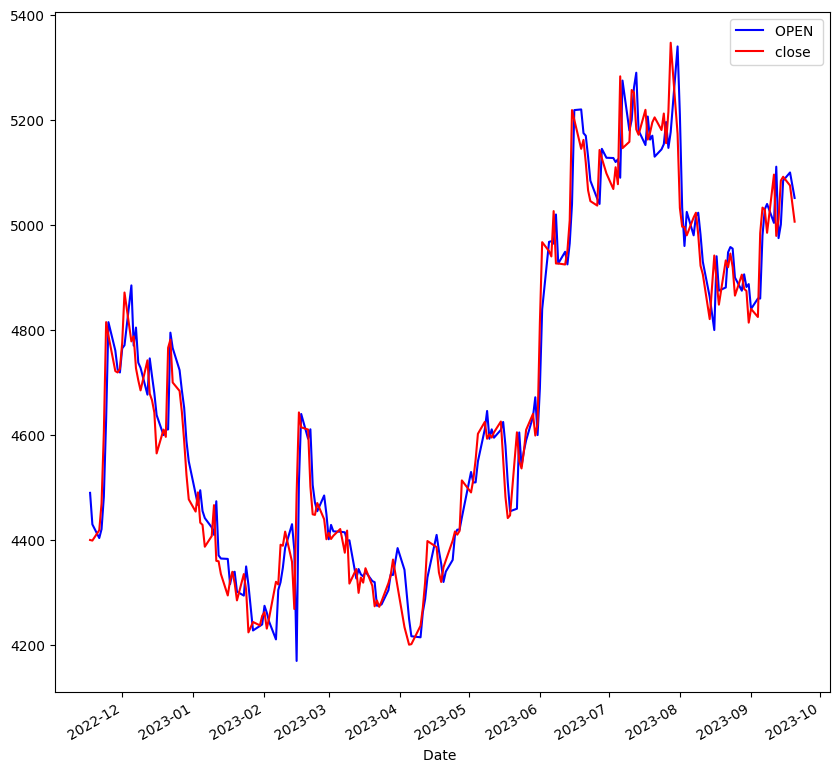

In [ ]:
apollo_train.plot(y = ["OPEN ", "close "], kind="line", figsize=(10, 10), color = ["blue", "red"])

## Training the Model

We first generate the new exogenous features via feature engineering.

In [ ]:
x_train = apollo_train[['OPEN ', 'VOLUME ', 'close ', 'HIGH ', 'LOW ', 'ltp ']]
x_val = apollo_val[['OPEN ', 'VOLUME ', 'close ', 'HIGH ', 'LOW ', 'ltp ']]

x_train['Interaction_Feature'] = x_train['OPEN '] * x_train['VOLUME ']

x_train['Open_Lag1'] = x_train['OPEN '].shift(1)
x_train['Open_Lag2'] = x_train['OPEN '].shift(2)
x_train['Open_Lag3'] = x_train['OPEN '].shift(3)
x_train['Open_Lag4'] = x_train['OPEN '].shift(4)

x_train['Volume_Lag1'] = x_train['VOLUME '].shift(1)
x_train['Volume_Lag2'] = x_train['VOLUME '].shift(2)
x_train['Volume_Lag3'] = x_train['VOLUME '].shift(3)
x_train['Volume_Lag4'] = x_train['VOLUME '].shift(3)

x_train['Open_ma5'] = x_train['OPEN '].rolling(5).mean()
x_train['Open_ma8'] = x_train['OPEN '].rolling(8).mean()
x_train['Open_ma10'] = x_train['OPEN '].rolling(10).mean()

x_train['Volume_ma5'] = x_train['VOLUME '].rolling(5).mean()
x_train['Volume_ma8'] = x_train['VOLUME '].rolling(8).mean()
x_train['Volume_ma10'] = x_train['VOLUME '].rolling(10).mean()

<ipython-input-11-fe2a5fadd16b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Interaction_Feature'] = x_train['OPEN '] * x_train['VOLUME ']
<ipython-input-11-fe2a5fadd16b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Open_Lag1'] = x_train['OPEN '].shift(1)
<ipython-input-11-fe2a5fadd16b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [ ]:
x_val['Interaction_Feature'] = x_val['OPEN '] * x_val['VOLUME ']

x_val['Open_Lag1'] = x_val['OPEN '].shift(1)
x_val['Open_Lag2'] = x_val['OPEN '].shift(2)
x_val['Open_Lag3'] = x_val['OPEN '].shift(3)
x_val['Open_Lag4'] = x_val['OPEN '].shift(4)

x_val['Volume_Lag1'] = x_val['VOLUME '].shift(1)
x_val['Volume_Lag2'] = x_val['VOLUME '].shift(2)
x_val['Volume_Lag3'] = x_val['VOLUME '].shift(3)
x_val['Volume_Lag4'] = x_val['VOLUME '].shift(3)

x_val['Open_ma5'] = x_val['OPEN '].rolling(5).mean()
x_val['Open_ma8'] = x_val['OPEN '].rolling(8).mean()
x_val['Open_ma10'] = x_val['OPEN '].rolling(10).mean()

x_val['Volume_ma5'] = x_val['VOLUME '].rolling(5).mean()
x_val['Volume_ma8'] = x_val['VOLUME '].rolling(8).mean()
x_val['Volume_ma10'] = x_val['VOLUME '].rolling(10).mean()

<ipython-input-12-08a16567eb51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Interaction_Feature'] = x_val['OPEN '] * x_val['VOLUME ']
<ipython-input-12-08a16567eb51>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Open_Lag1'] = x_val['OPEN '].shift(1)
<ipython-input-12-08a16567eb51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
x_train = x_train.dropna()
x_train

,OPEN,VOLUME,close,HIGH,LOW,ltp,Interaction_Feature,Open_Lag1,Open_Lag2,Open_Lag3,...,Volume_Lag1,Volume_Lag2,Volume_Lag3,Volume_Lag4,Open_ma5,Open_ma8,Open_ma10,Volume_ma5,Volume_ma8,Volume_ma10
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-30,4719.20,1113421.0,4726.40,4760.10,4642.60,4729.95,5.254456e+09,4725.00,4761.00,4815.0,...,910558.0,598162.0,1069669.0,1069669.0,4730.04,4619.67500,4587.740,1102884.0,870145.375,777749.0
2022-12-01,4765.00,611403.0,4775.70,4794.00,4701.05,4770.00,2.913335e+09,4719.20,4725.00,4761.0,...,1113421.0,910558.0,598162.0,598162.0,4757.04,4664.80625,4615.240,860642.6,904487.750,795827.1
2022-12-02,4771.00,996306.0,4871.45,4882.95,4743.05,4864.90,4.753376e+09,4765.00,4719.20,4725.0,...,611403.0,1113421.0,910558.0,910558.0,4748.24,4708.56250,4649.340,845970.0,990193.875,856887.2
2022-12-05,4885.00,684834.0,4778.35,4901.95,4766.95,4775.00,3.345414e+09,4771.00,4765.00,4719.2,...,996306.0,611403.0,1113421.0,1113421.0,4773.04,4758.90000,4697.445,863304.4,975870.375,891704.2
2022-12-06,4770.35,354855.0,4788.05,4800.00,4715.00,4795.00,1.692783e+09,4885.00,4771.00,4765.0,...,684834.0,996306.0,611403.0,611403.0,4782.11,4776.44375,4732.385,752163.8,792401.000,896124.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,4975.00,232238.0,5011.00,5021.20,4945.00,5021.20,1.155384e+09,5111.00,5004.00,5040.0,...,483061.0,543287.0,292671.0,292671.0,5031.99,4982.49375,4958.740,377193.2,447046.625,427073.0
2023-09-14,5001.00,414391.0,5084.55,5100.00,4995.50,5086.05,2.072369e+09,4975.00,5111.00,5004.0,...,232238.0,483061.0,543287.0,543287.0,5026.20,5000.11875,4970.095,393129.6,454539.750,419686.1
2023-09-15,5084.55,658355.0,5091.80,5150.40,5061.70,5100.00,3.347439e+09,5001.00,4975.00,5111.0,...,414391.0,232238.0,483061.0,483061.0,5035.11,5028.18750,4994.550,466266.4,436764.875,464911.9


In [ ]:
x_val = x_val.dropna()
x_val

,OPEN,VOLUME,close,HIGH,LOW,ltp,Interaction_Feature,Open_Lag1,Open_Lag2,Open_Lag3,...,Volume_Lag1,Volume_Lag2,Volume_Lag3,Volume_Lag4,Open_ma5,Open_ma8,Open_ma10,Volume_ma5,Volume_ma8,Volume_ma10
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-06,5050.00,407753.0,5060.25,5084.00,5028.80,5059.00,2.059153e+09,5054.95,5085.00,5138.95,...,363289.0,442482.0,268482.0,268482.0,5076.58,5079.90625,5066.715,378514.60,378519.625,376336.20
2023-10-09,5000.00,176296.0,5047.30,5066.00,4987.05,5040.00,8.814800e+08,5050.00,5054.95,5085.00,...,407753.0,363289.0,442482.0,442482.0,5065.78,5067.78125,5065.415,331660.40,367168.875,359119.90
2023-10-10,5068.95,202645.0,5066.70,5084.55,5033.00,5063.95,1.027197e+09,5000.00,5050.00,5054.95,...,176296.0,407753.0,363289.0,363289.0,5051.78,5069.65000,5070.820,318493.00,334903.500,340709.80
2023-10-11,5072.95,336099.0,5092.85,5140.00,5065.00,5083.00,1.705013e+09,5068.95,5000.00,5050.00,...,202645.0,176296.0,407753.0,407753.0,5049.37,5065.60000,5068.415,297216.40,325951.625,347609.50
2023-10-12,5092.80,1029595.0,4993.85,5113.95,4871.70,4995.05,5.243521e+09,5072.95,5068.95,5000.00,...,336099.0,202645.0,176296.0,176296.0,5056.94,5070.45000,5072.295,430477.60,403330.125,404492.20
2023-10-13,4988.95,410013.0,5017.30,5029.10,4933.75,5017.00,2.045534e+09,5092.80,5072.95,5068.95,...,1029595.0,336099.0,202645.0,202645.0,5044.73,5051.70000,5060.655,430929.60,421021.500,404722.10
2023-10-16,5030.00,259806.0,5021.70,5049.45,4986.40,5021.00,1.306824e+09,4988.95,5092.80,5072.95,...,410013.0,1029595.0,336099.0,336099.0,5050.73,5044.82500,5058.255,447631.60,398187.000,389646.00
2023-10-17,5050.00,217907.0,5028.80,5068.00,5012.20,5026.95,1.100430e+09,5030.00,4988.95,5092.80,...,259806.0,410013.0,1029595.0,1029595.0,5046.94,5044.20625,5049.360,450684.00,380014.250,384588.50
2023-10-18,5021.00,341459.0,4977.25,5039.95,4938.45,4979.00,1.714466e+09,5050.00,5030.00,4988.95,...,217907.0,259806.0,410013.0,410013.0,5036.55,5040.58125,5042.960,451756.00,371727.500,374486.20


Now, we fit a SARIMAX model to predict `CLOSE`. We pass some original features and some engineered features as exogenous variables. We also select appropriate orders.

In [ ]:
exog = sm.add_constant(x_train[['OPEN ', 'VOLUME ', 'HIGH ', 'LOW ', 'Interaction_Feature', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Open_ma5', 'Open_ma8', 'Open_ma10', 'Volume_ma5', 'Volume_ma8', 'Volume_ma10']])

apollo_sarimax_model = SARIMAX(endog = x_train['close '], exog=exog, order=(5, 1, 3), seasonal_order=(1, 1, 1, 12))
apollo_sarimax_model_fit = apollo_sarimax_model.fit(disp = False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

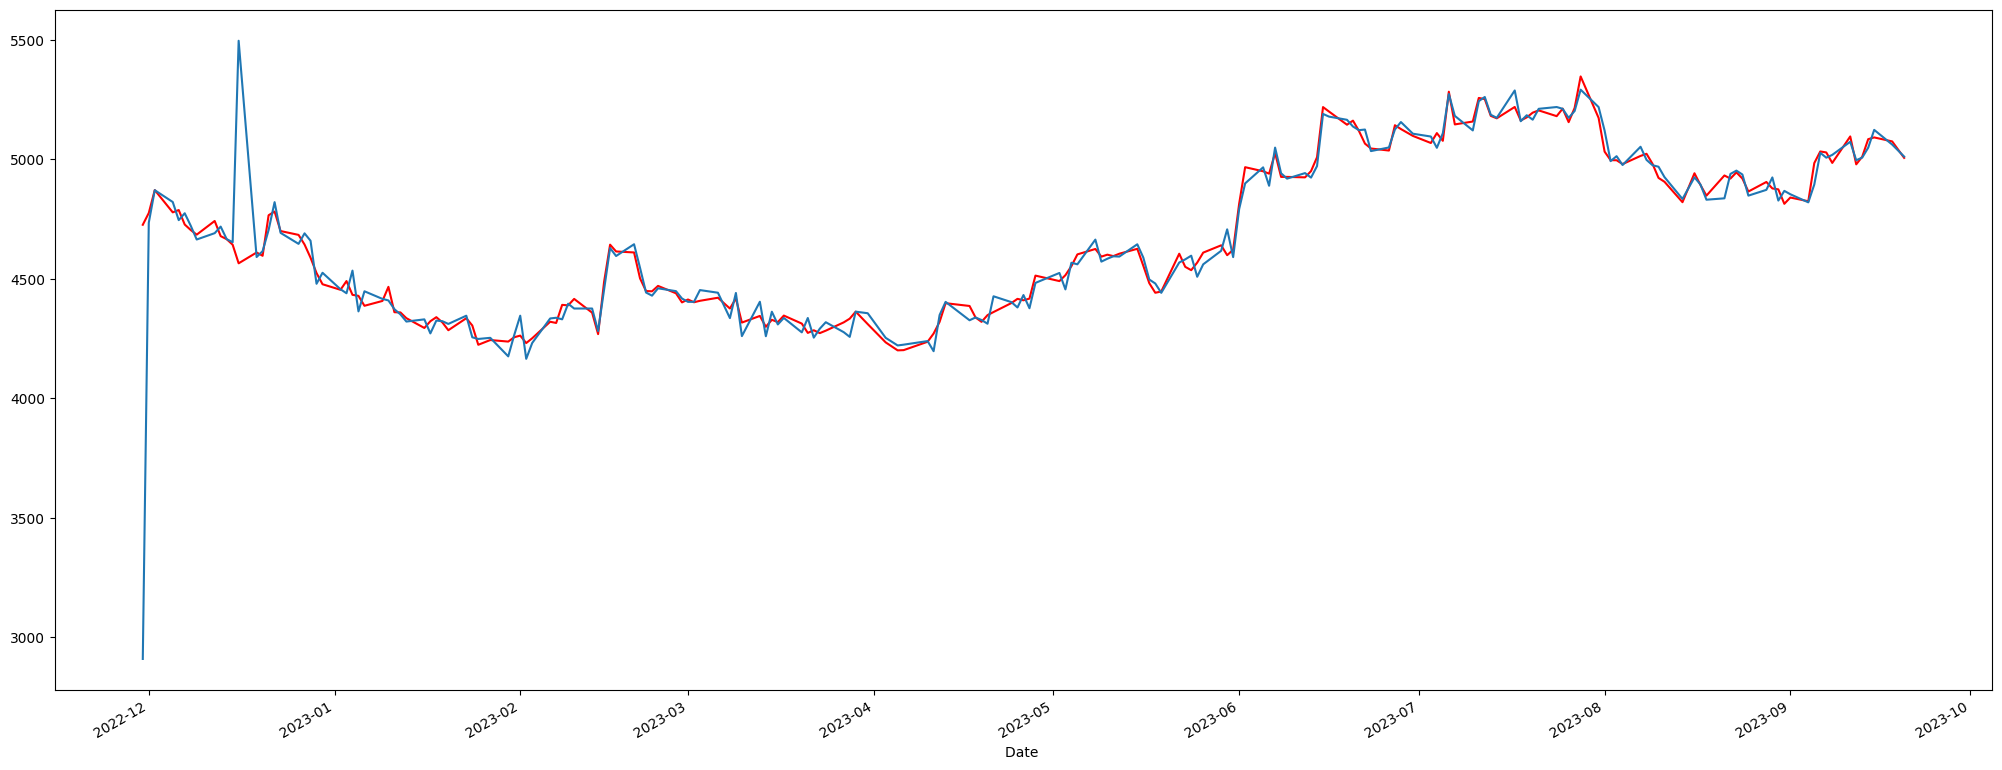

In [ ]:
import matplotlib.pyplot as plt

x_train['close '].plot(figsize=(25,10), color = "red")
apollo_sarimax_model_fit.fittedvalues.plot()
plt.show()

Now, we will use this fitted model to forecast the `CLOSE` values for the val set and compare them with the true values to see how well our model is doing.\\

We will use SMAPE to determine how well our model is performing.

In [ ]:
apollo_sarima_predict = apollo_sarimax_model_fit.predict(start = len(x_train), end = len(x_train) + len(x_val)-1,exog = sm.add_constant(x_val[['OPEN ', 'VOLUME ', 'HIGH ', 'LOW ', 'Interaction_Feature', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Open_ma5', 'Open_ma8', 'Open_ma10', 'Volume_ma5', 'Volume_ma8', 'Volume_ma10']]))
x_val['close_predicted'] = apollo_sarima_predict.values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date '>

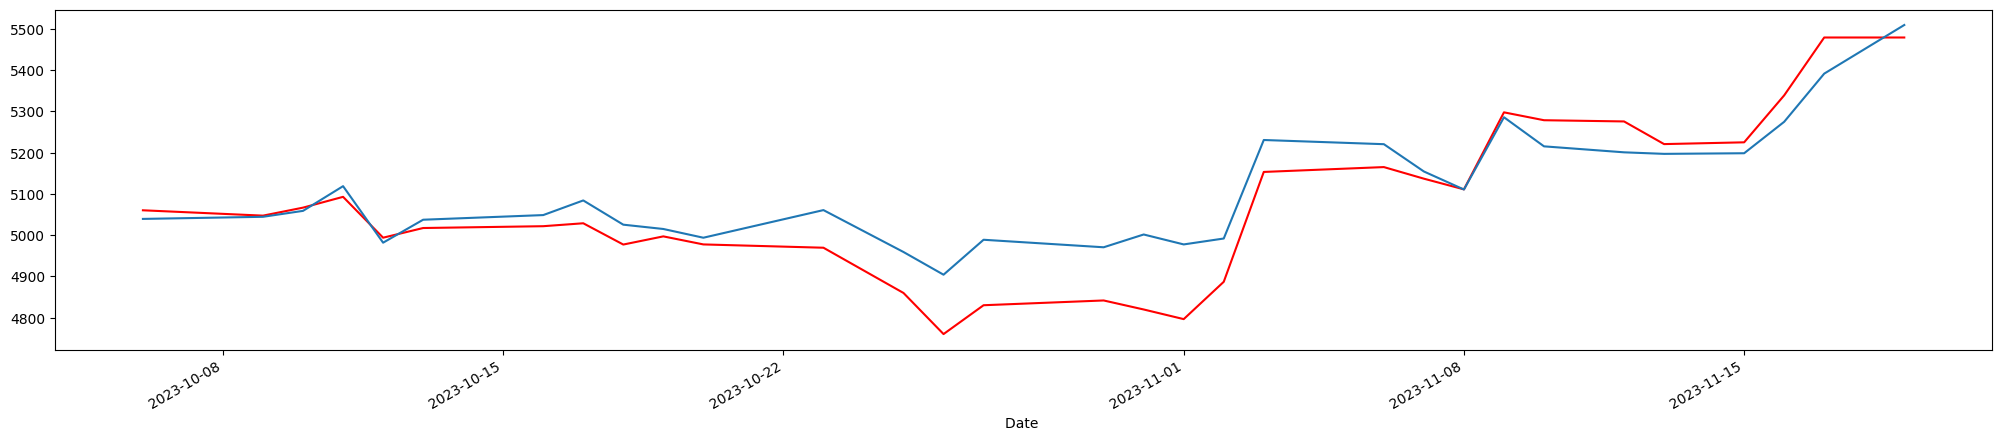

In [ ]:
x_val['close '].plot(figsize=(25,5), color = "red")
x_val['close_predicted'].plot(figsize=(25,5))

In [ ]:
smape = np.mean(np.abs(x_val['close_predicted'] - x_val['close ']) / (np.abs(x_val['close_predicted']) + np.abs(x_val['close '])))
smape

0.006023728043034857

As we can see, the model seems to be performing pretty well. \\
We will now store the predicted value for later.

In [ ]:
apollo_pred = x_val['close_predicted'][30]

# AsianPaints Prediction

In [ ]:
asian_df = pd.read_csv('asianpaints.csv')
asian_df = asian_df.iloc[::-1]

In [ ]:
asian_df['Date '] = asian_df['Date '].apply(string_to_datetime)

asian_df['OPEN '] = asian_df['OPEN '].apply(remove_comma).astype(float)
asian_df['HIGH '] = asian_df['HIGH '].apply(remove_comma).astype(float)
asian_df['LOW '] = asian_df['LOW '].apply(remove_comma).astype(float)
asian_df['PREV. CLOSE '] = asian_df['PREV. CLOSE '].apply(remove_comma).astype(float)
asian_df['ltp '] = asian_df['ltp '].apply(remove_comma).astype(float)
asian_df['close '] = asian_df['close '].apply(remove_comma).astype(float)
asian_df['vwap '] = asian_df['vwap '].apply(remove_comma).astype(float)
asian_df['52W H '] = asian_df['52W H '].apply(remove_comma).astype(float)
asian_df['52W L '] = asian_df['52W L '].apply(remove_comma).astype(float)
asian_df['VOLUME '] = asian_df['VOLUME '].apply(remove_comma).astype(float)
asian_df['VALUE '] = asian_df['VALUE '].apply(remove_comma).astype(float)

asian_df.reset_index(inplace = True)
asian_df.drop(columns = ['index'], inplace = True)

asian_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2022-11-17,EQ,3092.00,3096.55,3060.00,3083.05,3061.90,3071.60,3079.61,3590.0,2560.00,706271.0,2.175039e+09,"46,590"
1,2022-11-18,EQ,3095.00,3114.85,3055.75,3071.60,3100.00,3095.50,3087.88,3590.0,2560.00,1258576.0,3.886330e+09,"96,466"
2,2022-11-21,EQ,3105.00,3110.35,3066.20,3095.50,3092.00,3095.30,3089.68,3590.0,2560.00,612194.0,1.891481e+09,"45,258"
3,2022-11-22,EQ,3104.00,3119.50,3072.30,3095.30,3104.80,3103.85,3105.36,3590.0,2560.00,764079.0,2.372740e+09,"58,127"
4,2022-11-23,EQ,3111.00,3114.80,3090.00,3103.85,3096.35,3100.80,3101.49,3590.0,2560.00,488341.0,1.514585e+09,"37,792"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-12,EQ,3099.95,3100.00,3090.00,3076.45,3099.50,3098.15,3097.92,3568.0,2685.85,85178.0,2.638747e+08,"14,342"
246,2023-11-13,EQ,3098.00,3098.00,3065.00,3098.15,3083.00,3085.60,3079.60,3568.0,2685.85,405941.0,1.250134e+09,"38,458"
247,2023-11-15,EQ,3085.70,3118.85,3078.70,3085.60,3115.80,3116.20,3101.22,3568.0,2685.85,700017.0,2.170907e+09,"64,696"
248,2023-11-16,EQ,3119.00,3140.90,3097.60,3116.20,3131.10,3130.30,3125.99,3568.0,2685.85,675454.0,2.111464e+09,"70,056"


In [ ]:
asian_df['Volume_ma5'] = asian_df['VOLUME '].rolling(5).mean()
asian_df['ltp_ma5'] = asian_df['ltp '].rolling(5).mean()

asian_df['Low_ema'] = asian_df['LOW '].ewm(com = 2.5).mean()
asian_df['High_ema'] = asian_df['HIGH '].ewm(com = 2.5).mean()

asian_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,Volume_ma5,ltp_ma5,Low_ema,High_ema
0,2022-11-17,EQ,3092.00,3096.55,3060.00,3083.05,3061.90,3071.60,3079.61,3590.0,2560.00,706271.0,2.175039e+09,"46,590",NaN,NaN,3060.000000,3096.550000
1,2022-11-18,EQ,3095.00,3114.85,3055.75,3071.60,3100.00,3095.50,3087.88,3590.0,2560.00,1258576.0,3.886330e+09,"96,466",NaN,NaN,3057.520833,3107.225000
2,2022-11-21,EQ,3105.00,3110.35,3066.20,3095.50,3092.00,3095.30,3089.68,3590.0,2560.00,612194.0,1.891481e+09,"45,258",NaN,NaN,3061.422477,3108.629817
3,2022-11-22,EQ,3104.00,3119.50,3072.30,3095.30,3104.80,3103.85,3105.36,3590.0,2560.00,764079.0,2.372740e+09,"58,127",NaN,NaN,3065.624043,3112.828547
4,2022-11-23,EQ,3111.00,3114.80,3090.00,3103.85,3096.35,3100.80,3101.49,3590.0,2560.00,488341.0,1.514585e+09,"37,792",765892.2,3091.01,3074.179323,3113.520472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-12,EQ,3099.95,3100.00,3090.00,3076.45,3099.50,3098.15,3097.92,3568.0,2685.85,85178.0,2.638747e+08,"14,342",568102.0,3079.10,3042.540569,3077.364350
246,2023-11-13,EQ,3098.00,3098.00,3065.00,3098.15,3083.00,3085.60,3079.60,3568.0,2685.85,405941.0,1.250134e+09,"38,458",497690.6,3088.10,3048.957549,3083.260250
247,2023-11-15,EQ,3085.70,3118.85,3078.70,3085.60,3115.80,3116.20,3101.22,3568.0,2685.85,700017.0,2.170907e+09,"64,696",481014.0,3091.66,3057.455392,3093.428750
248,2023-11-16,EQ,3119.00,3140.90,3097.60,3116.20,3131.10,3130.30,3125.99,3568.0,2685.85,675454.0,2.111464e+09,"70,056",446164.4,3101.88,3068.925280,3106.991964


In [ ]:
new_row = {'Date ': pd.to_datetime('2023-11-19'), 'OPEN ': asian_df.iloc[249]['close '], 'VOLUME ': asian_df.iloc[249]['Volume_ma5'] + 60, 'LOW ': asian_df.iloc[249]['Low_ema'] + 60, 'HIGH ': asian_df.iloc[249]['High_ema'] + 60, 'ltp ': asian_df.iloc[249]['ltp_ma5'] + 60, 'close ': asian_df.iloc[249]['close ']}
asian_df.loc[len(asian_df)] = new_row

asian_df.drop(columns=['Volume_ma5', 'ltp_ma5', 'Low_ema', 'High_ema'], inplace = True)
asian_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2022-11-17,EQ,3092.0,3096.550000,3060.000000,3083.05,3061.90,3071.60,3079.61,3590.0,2560.00,706271.0,2.175039e+09,"46,590"
1,2022-11-18,EQ,3095.0,3114.850000,3055.750000,3071.60,3100.00,3095.50,3087.88,3590.0,2560.00,1258576.0,3.886330e+09,"96,466"
2,2022-11-21,EQ,3105.0,3110.350000,3066.200000,3095.50,3092.00,3095.30,3089.68,3590.0,2560.00,612194.0,1.891481e+09,"45,258"
3,2022-11-22,EQ,3104.0,3119.500000,3072.300000,3095.30,3104.80,3103.85,3105.36,3590.0,2560.00,764079.0,2.372740e+09,"58,127"
4,2022-11-23,EQ,3111.0,3114.800000,3090.000000,3103.85,3096.35,3100.80,3101.49,3590.0,2560.00,488341.0,1.514585e+09,"37,792"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2023-11-13,EQ,3098.0,3098.000000,3065.000000,3098.15,3083.00,3085.60,3079.60,3568.0,2685.85,405941.0,1.250134e+09,"38,458"
247,2023-11-15,EQ,3085.7,3118.850000,3078.700000,3085.60,3115.80,3116.20,3101.22,3568.0,2685.85,700017.0,2.170907e+09,"64,696"
248,2023-11-16,EQ,3119.0,3140.900000,3097.600000,3116.20,3131.10,3130.30,3125.99,3568.0,2685.85,675454.0,2.111464e+09,"70,056"
249,2023-11-17,EQ,3150.0,3228.250000,3145.650000,3130.30,3167.00,3168.90,3196.91,3568.0,2685.85,1430175.0,4.572143e+09,"1,11,559"


In [ ]:
asian_df.set_index('Date ', inplace = True)
asian_df

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2022-11-17,EQ,3092.0,3096.550000,3060.000000,3083.05,3061.90,3071.60,3079.61,3590.0,2560.00,706271.0,2.175039e+09,"46,590"
2022-11-18,EQ,3095.0,3114.850000,3055.750000,3071.60,3100.00,3095.50,3087.88,3590.0,2560.00,1258576.0,3.886330e+09,"96,466"
2022-11-21,EQ,3105.0,3110.350000,3066.200000,3095.50,3092.00,3095.30,3089.68,3590.0,2560.00,612194.0,1.891481e+09,"45,258"
2022-11-22,EQ,3104.0,3119.500000,3072.300000,3095.30,3104.80,3103.85,3105.36,3590.0,2560.00,764079.0,2.372740e+09,"58,127"
2022-11-23,EQ,3111.0,3114.800000,3090.000000,3103.85,3096.35,3100.80,3101.49,3590.0,2560.00,488341.0,1.514585e+09,"37,792"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,EQ,3098.0,3098.000000,3065.000000,3098.15,3083.00,3085.60,3079.60,3568.0,2685.85,405941.0,1.250134e+09,"38,458"
2023-11-15,EQ,3085.7,3118.850000,3078.700000,3085.60,3115.80,3116.20,3101.22,3568.0,2685.85,700017.0,2.170907e+09,"64,696"
2023-11-16,EQ,3119.0,3140.900000,3097.600000,3116.20,3131.10,3130.30,3125.99,3568.0,2685.85,675454.0,2.111464e+09,"70,056"


In [ ]:
asian_train = asian_df[:210]
asian_train

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2022-11-17,EQ,3092.0,3096.55,3060.00,3083.05,3061.90,3071.60,3079.61,3590.0,2560.00,706271.0,2.175039e+09,"46,590"
2022-11-18,EQ,3095.0,3114.85,3055.75,3071.60,3100.00,3095.50,3087.88,3590.0,2560.00,1258576.0,3.886330e+09,"96,466"
2022-11-21,EQ,3105.0,3110.35,3066.20,3095.50,3092.00,3095.30,3089.68,3590.0,2560.00,612194.0,1.891481e+09,"45,258"
2022-11-22,EQ,3104.0,3119.50,3072.30,3095.30,3104.80,3103.85,3105.36,3590.0,2560.00,764079.0,2.372740e+09,"58,127"
2022-11-23,EQ,3111.0,3114.80,3090.00,3103.85,3096.35,3100.80,3101.49,3590.0,2560.00,488341.0,1.514585e+09,"37,792"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,EQ,3245.0,3284.65,3225.30,3256.85,3269.15,3277.75,3258.31,3582.9,2685.85,880907.0,2.870266e+09,"59,755"
2023-09-14,EQ,3282.0,3294.20,3223.25,3277.75,3240.00,3240.25,3245.86,3582.9,2685.85,1102554.0,3.578737e+09,"1,13,167"
2023-09-15,EQ,3235.0,3240.00,3185.00,3240.25,3200.00,3196.65,3198.14,3582.9,2685.85,1568607.0,5.016627e+09,"1,13,418"


In [ ]:
asian_val = asian_df[-40:]
asian_val

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2023-09-22,EQ,3234.95,3283.600000,3221.150000,3244.20,3280.50,3274.85,3262.19,3582.9,2685.85,896521.0,2.924622e+09,"79,565"
2023-09-25,EQ,3272.30,3334.800000,3271.150000,3274.85,3321.15,3323.25,3315.09,3582.9,2685.85,1422084.0,4.714336e+09,"1,04,864"
2023-09-26,EQ,3323.00,3324.900000,3260.350000,3323.25,3292.00,3292.80,3286.83,3582.9,2685.85,834560.0,2.743061e+09,"84,109"
2023-09-27,EQ,3288.00,3309.000000,3271.700000,3292.80,3307.60,3301.80,3294.21,3582.9,2685.85,516326.0,1.700885e+09,"55,381"
2023-09-28,EQ,3281.80,3289.000000,3155.000000,3301.80,3180.00,3170.35,3196.13,3582.9,2685.85,2104381.0,6.725874e+09,"1,59,596"
2023-09-29,EQ,3195.00,3195.000000,3134.000000,3170.35,3166.00,3161.05,3160.04,3582.9,2685.85,1550585.0,4.899913e+09,"1,04,346"
2023-10-03,EQ,3166.10,3227.800000,3162.000000,3161.05,3167.50,3166.85,3188.43,3568.0,2685.85,1219145.0,3.887155e+09,"90,310"
2023-10-04,EQ,3164.95,3189.000000,3151.350000,3166.85,3169.10,3169.90,3171.84,3568.0,2685.85,892584.0,2.831132e+09,"80,714"
2023-10-05,EQ,3210.00,3232.100000,3174.300000,3169.90,3202.00,3206.25,3200.15,3568.0,2685.85,1002610.0,3.208506e+09,"83,570"


<Axes: xlabel='Date '>

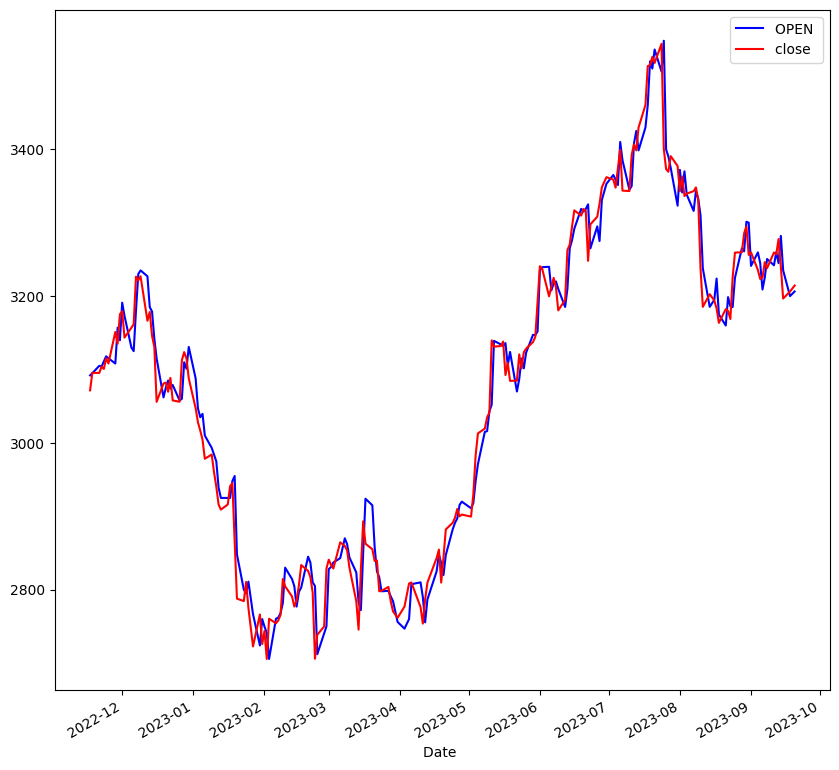

In [ ]:
asian_train.plot(y = ["OPEN ", "close "], kind="line", figsize=(10, 10), color = ["blue", "red"])

In [ ]:
del x_train
del x_val

x_train = asian_train[['OPEN ', 'VOLUME ', 'close ', 'HIGH ', 'LOW ', 'ltp ']]
x_val = asian_val[['OPEN ', 'VOLUME ', 'close ', 'HIGH ', 'LOW ', 'ltp ']]

x_train['Interaction_Feature'] = x_train['OPEN '] * x_train['VOLUME ']

x_train['Open_Lag1'] = x_train['OPEN '].shift(1)
x_train['Open_Lag2'] = x_train['OPEN '].shift(2)
x_train['Open_Lag3'] = x_train['OPEN '].shift(3)
x_train['Open_Lag4'] = x_train['OPEN '].shift(4)

x_train['Volume_Lag1'] = x_train['VOLUME '].shift(1)
x_train['Volume_Lag2'] = x_train['VOLUME '].shift(2)
x_train['Volume_Lag3'] = x_train['VOLUME '].shift(3)
x_train['Volume_Lag4'] = x_train['VOLUME '].shift(3)

x_train['Open_ma5'] = x_train['OPEN '].rolling(5).mean()
x_train['Open_ma8'] = x_train['OPEN '].rolling(8).mean()
x_train['Open_ma10'] = x_train['OPEN '].rolling(10).mean()

x_train['Volume_ma5'] = x_train['VOLUME '].rolling(5).mean()
x_train['Volume_ma8'] = x_train['VOLUME '].rolling(8).mean()
x_train['Volume_ma10'] = x_train['VOLUME '].rolling(10).mean()

<ipython-input-29-a42cdc667a10>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Interaction_Feature'] = x_train['OPEN '] * x_train['VOLUME ']
<ipython-input-29-a42cdc667a10>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Open_Lag1'] = x_train['OPEN '].shift(1)
<ipython-input-29-a42cdc667a10>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [ ]:
x_val['Interaction_Feature'] = x_val['OPEN '] * x_val['VOLUME ']

x_val['Open_Lag1'] = x_val['OPEN '].shift(1)
x_val['Open_Lag2'] = x_val['OPEN '].shift(2)
x_val['Open_Lag3'] = x_val['OPEN '].shift(3)
x_val['Open_Lag4'] = x_val['OPEN '].shift(4)

x_val['Volume_Lag1'] = x_val['VOLUME '].shift(1)
x_val['Volume_Lag2'] = x_val['VOLUME '].shift(2)
x_val['Volume_Lag3'] = x_val['VOLUME '].shift(3)
x_val['Volume_Lag4'] = x_val['VOLUME '].shift(3)

x_val['Open_ma5'] = x_val['OPEN '].rolling(5).mean()
x_val['Open_ma8'] = x_val['OPEN '].rolling(8).mean()
x_val['Open_ma10'] = x_val['OPEN '].rolling(10).mean()

x_val['Volume_ma5'] = x_val['VOLUME '].rolling(5).mean()
x_val['Volume_ma8'] = x_val['VOLUME '].rolling(8).mean()
x_val['Volume_ma10'] = x_val['VOLUME '].rolling(10).mean()

<ipython-input-30-08a16567eb51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Interaction_Feature'] = x_val['OPEN '] * x_val['VOLUME ']
<ipython-input-30-08a16567eb51>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Open_Lag1'] = x_val['OPEN '].shift(1)
<ipython-input-30-08a16567eb51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
x_train = x_train.dropna()
x_train

,OPEN,VOLUME,close,HIGH,LOW,ltp,Interaction_Feature,Open_Lag1,Open_Lag2,Open_Lag3,...,Volume_Lag1,Volume_Lag2,Volume_Lag3,Volume_Lag4,Open_ma5,Open_ma8,Open_ma10,Volume_ma5,Volume_ma8,Volume_ma10
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-30,3139.90,2547283.0,3175.15,3199.95,3133.30,3183.35,7.998214e+09,3157.00,3108.15,3115.30,...,877720.0,914689.0,898769.0,898769.0,3127.66,3119.78750,3114.530,1162066.6,959368.375,963979.4
2022-12-01,3191.00,761717.0,3179.35,3197.00,3161.25,3174.00,2.430639e+09,3139.90,3157.00,3108.15,...,2547283.0,877720.0,914689.0,914689.0,3142.27,3130.53750,3124.430,1200035.6,978058.750,969524.0
2022-12-02,3173.15,932259.0,3143.45,3174.30,3134.00,3143.00,2.958198e+09,3191.00,3139.90,3157.00,...,761717.0,2547283.0,877720.0,877720.0,3153.84,3139.18125,3132.245,1206733.6,999081.250,936892.3
2022-12-05,3130.00,926122.0,3156.90,3168.70,3112.50,3152.05,2.898762e+09,3173.15,3191.00,3139.90,...,932259.0,761717.0,2547283.0,2547283.0,3158.21,3141.55625,3134.745,1209020.2,1053803.875,968285.1
2022-12-06,3125.00,958365.0,3161.70,3169.00,3125.00,3164.85,2.994891e+09,3130.00,3173.15,3191.00,...,926122.0,932259.0,761717.0,761717.0,3151.81,3142.43750,3136.845,1225149.2,1102115.500,987713.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,3245.00,880907.0,3277.75,3284.65,3225.30,3269.15,2.858543e+09,3260.00,3242.00,3250.55,...,554905.0,359345.0,395918.0,395918.0,3244.57,3242.05000,3247.755,622836.6,645190.500,741362.2
2023-09-14,3282.00,1102554.0,3240.25,3294.20,3223.25,3240.00,3.618582e+09,3245.00,3260.00,3242.00,...,880907.0,554905.0,359345.0,359345.0,3255.91,3244.85625,3245.950,658725.8,695983.125,691420.9
2023-09-15,3235.00,1568607.0,3196.65,3240.00,3185.00,3200.00,5.074444e+09,3282.00,3245.00,3260.00,...,1102554.0,880907.0,554905.0,554905.0,3252.80,3243.60625,3245.340,893263.6,817431.250,783268.5


In [ ]:
x_val = x_val.dropna()
x_val

,OPEN,VOLUME,close,HIGH,LOW,ltp,Interaction_Feature,Open_Lag1,Open_Lag2,Open_Lag3,...,Volume_Lag1,Volume_Lag2,Volume_Lag3,Volume_Lag4,Open_ma5,Open_ma8,Open_ma10,Volume_ma5,Volume_ma8,Volume_ma10
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-06,3214.75,814257.0,3195.75,3217.000000,3190.000000,3197.00,2.617633e+09,3210.00,3164.95,3166.10,...,1002610.0,892584.0,1219145.0,1219145.0,3190.16,3230.45000,3235.085,1095836.2,1116806.000,1125305.3
2023-10-09,3140.05,700012.0,3152.80,3163.000000,3132.700000,3152.00,2.198073e+09,3214.75,3210.00,3164.95,...,814257.0,1002610.0,892584.0,892584.0,3179.17,3207.58125,3225.595,925721.6,1099987.500,1105654.4
2023-10-10,3150.00,847367.0,3151.50,3164.900000,3140.050000,3152.95,2.669206e+09,3140.05,3214.75,3210.00,...,700012.0,814257.0,1002610.0,1002610.0,3175.95,3190.33125,3213.365,851366.0,1141367.625,1048182.7
2023-10-11,3169.00,1025317.0,3163.90,3185.000000,3152.050000,3164.00,3.249230e+09,3150.00,3140.05,3214.75,...,847367.0,700012.0,814257.0,814257.0,3176.76,3176.23125,3197.965,877912.6,1006484.625,1067258.4
2023-10-12,3186.00,992531.0,3159.10,3188.500000,3150.050000,3162.00,3.162204e+09,3169.00,3150.00,3140.05,...,1025317.0,847367.0,700012.0,700012.0,3171.96,3175.10625,3187.765,875896.8,936727.875,1114878.9
2023-10-13,3150.00,854688.0,3148.80,3172.000000,3128.250000,3148.00,2.692267e+09,3186.00,3169.00,3150.00,...,992531.0,1025317.0,847367.0,847367.0,3159.01,3173.09375,3174.585,883983.0,891170.750,989909.6
2023-10-16,3124.00,853011.0,3112.05,3128.000000,3096.100000,3112.00,2.664806e+09,3150.00,3186.00,3169.00,...,854688.0,992531.0,1025317.0,1025317.0,3155.80,3167.97500,3167.485,914582.8,886224.125,920152.2
2023-10-17,3137.00,792640.0,3113.55,3137.000000,3091.800000,3116.90,2.486512e+09,3124.00,3150.00,3186.00,...,853011.0,854688.0,992531.0,992531.0,3153.20,3158.85000,3164.575,903637.4,859977.875,877501.7
2023-10-18,3110.00,481985.0,3096.45,3115.200000,3090.000000,3095.25,1.498973e+09,3137.00,3124.00,3150.00,...,792640.0,853011.0,854688.0,854688.0,3141.40,3145.75625,3159.080,794971.0,818443.875,836441.8


In [ ]:
exog = sm.add_constant(x_train[['OPEN ', 'VOLUME ', 'HIGH ', 'LOW ', 'Interaction_Feature', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Open_ma5', 'Open_ma8', 'Open_ma10', 'Volume_ma5', 'Volume_ma8', 'Volume_ma10']])

asian_sarimax_model = SARIMAX(endog = x_train['close '], exog=exog, order=(5, 1, 1), seasonal_order=(1, 1, 1, 12))
asian_sarimax_model_fit = asian_sarimax_model.fit(disp = False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


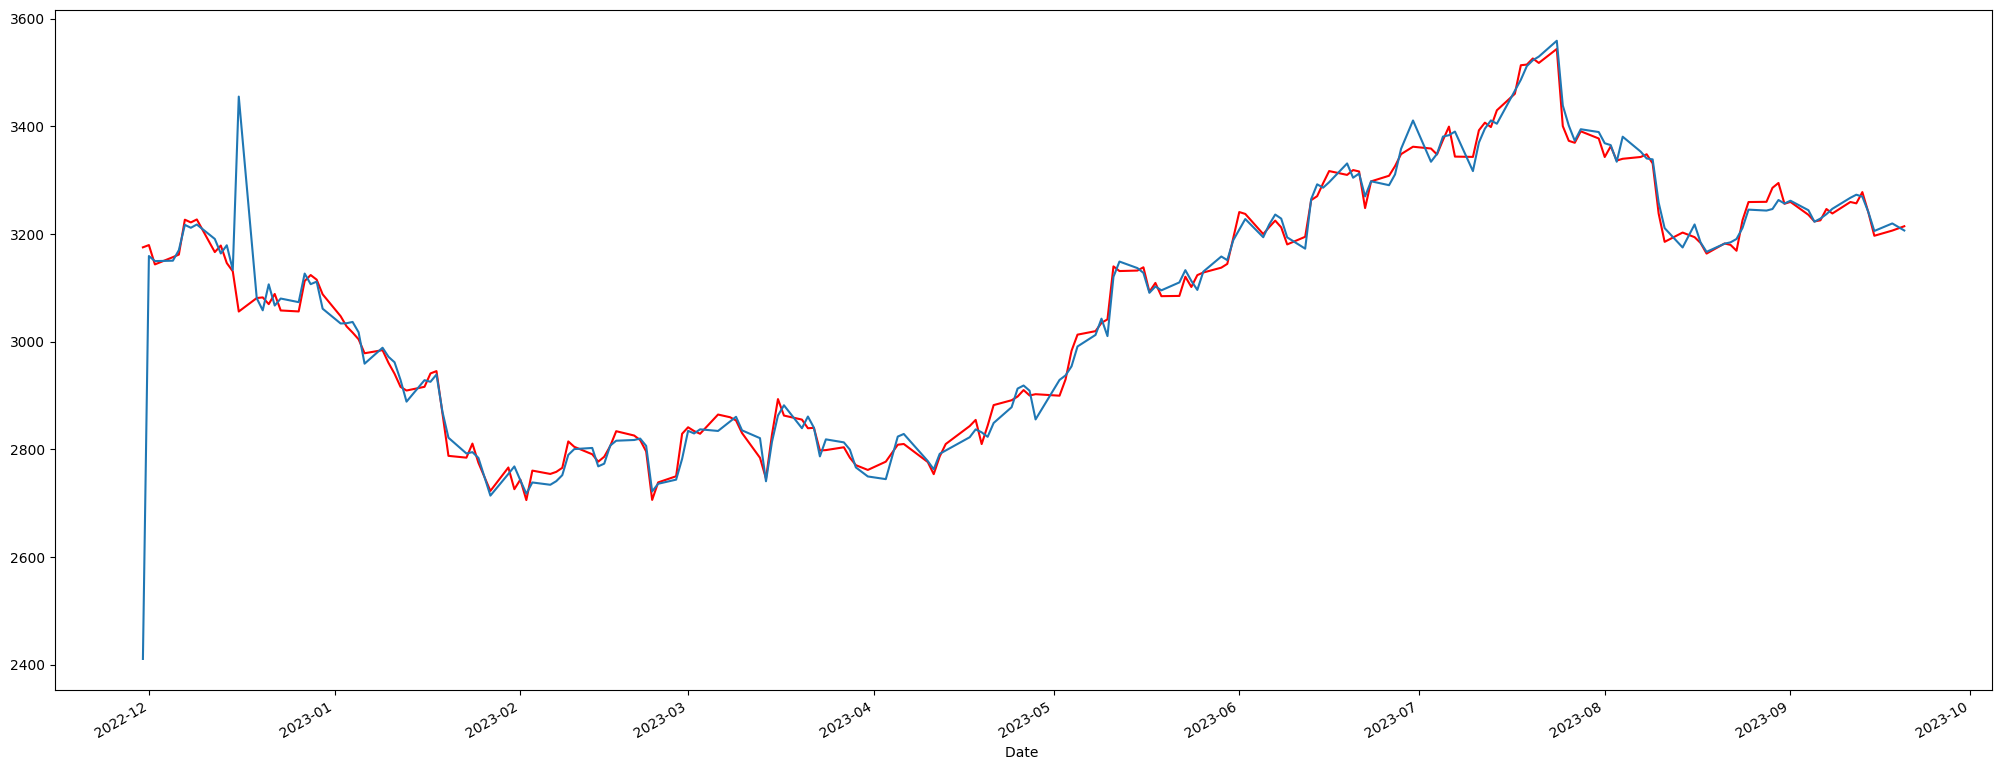

In [ ]:
import matplotlib.pyplot as plt

x_train['close '].plot(figsize=(25,10), color = "red")
asian_sarimax_model_fit.fittedvalues.plot()
plt.show()

In [ ]:
asian_sarima_predict = asian_sarimax_model_fit.predict(start = len(x_train), end = len(x_train) + len(x_val)-1,exog = sm.add_constant(x_val[['OPEN ', 'VOLUME ', 'HIGH ', 'LOW ', 'Interaction_Feature', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Open_ma5', 'Open_ma8', 'Open_ma10', 'Volume_ma5', 'Volume_ma8', 'Volume_ma10']]))
x_val['close_predicted'] = asian_sarima_predict.values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date '>

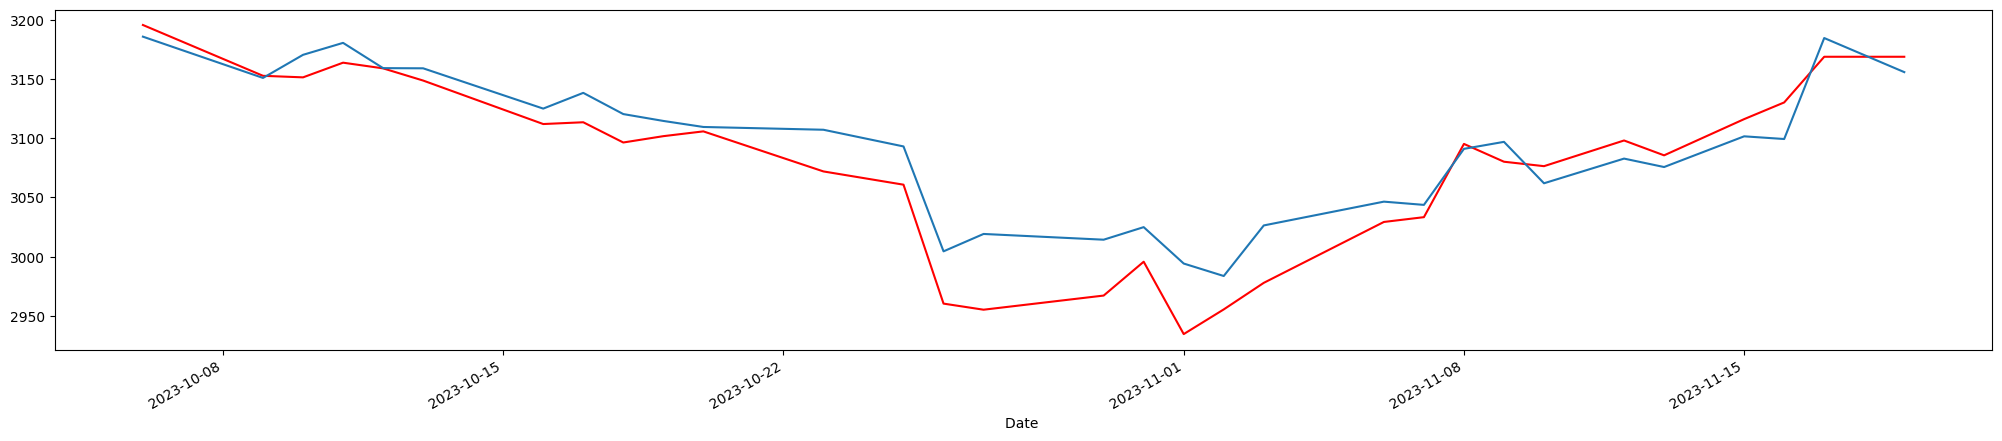

In [ ]:
x_val['close '].plot(figsize=(25,5), color = "red")
x_val['close_predicted'].plot(figsize=(25,5))

In [ ]:
smape = np.mean(np.abs(x_val['close_predicted'] - x_val['close ']) / (np.abs(x_val['close_predicted']) + np.abs(x_val['close '])))
smape

0.003634010383513973

In [ ]:
asian_pred = x_val['close_predicted'][30]
asian_pred

3155.9255723245788

# Titan Prediction

In [ ]:
titan_df = pd.read_csv('titan.csv')
titan_df = titan_df.iloc[::-1]

In [ ]:
titan_df['Date '] = titan_df['Date '].apply(string_to_datetime)

titan_df['OPEN '] = titan_df['OPEN '].apply(remove_comma).astype(float)
titan_df['HIGH '] = titan_df['HIGH '].apply(remove_comma).astype(float)
titan_df['LOW '] = titan_df['LOW '].apply(remove_comma).astype(float)
titan_df['PREV. CLOSE '] = titan_df['PREV. CLOSE '].apply(remove_comma).astype(float)
titan_df['ltp '] = titan_df['ltp '].apply(remove_comma).astype(float)
titan_df['close '] = titan_df['close '].apply(remove_comma).astype(float)
titan_df['vwap '] = titan_df['vwap '].apply(remove_comma).astype(float)
titan_df['52W H '] = titan_df['52W H '].apply(remove_comma).astype(float)
titan_df['52W L '] = titan_df['52W L '].apply(remove_comma).astype(float)
titan_df['VOLUME '] = titan_df['VOLUME '].apply(remove_comma).astype(float)
titan_df['VALUE '] = titan_df['VALUE '].apply(remove_comma).astype(float)

titan_df.reset_index(inplace = True)
titan_df.drop(columns = ['index'], inplace = True)

titan_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2022-11-17,EQ,2638.00,2645.00,2576.00,2644.30,2583.95,2582.00,2592.35,2791.0,1825.05,1265647.0,3.281003e+09,"69,687"
1,2022-11-18,EQ,2580.00,2583.40,2545.00,2582.00,2572.95,2565.80,2560.49,2791.0,1825.05,1038751.0,2.659708e+09,"99,791"
2,2022-11-21,EQ,2552.00,2578.95,2539.65,2565.80,2572.00,2573.35,2560.52,2791.0,1825.05,629040.0,1.610668e+09,"44,737"
3,2022-11-22,EQ,2580.00,2609.00,2561.00,2573.35,2607.50,2606.20,2594.84,2791.0,1825.05,912070.0,2.366678e+09,"58,060"
4,2022-11-23,EQ,2614.95,2632.50,2590.80,2606.20,2591.60,2601.75,2617.17,2791.0,1825.05,992873.0,2.598516e+09,"59,217"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-12,EQ,3300.00,3320.00,3265.00,3256.35,3281.95,3280.60,3282.02,3352.0,2269.60,204514.0,6.712185e+08,"21,534"
246,2023-11-13,EQ,3275.00,3278.35,3250.60,3280.60,3265.90,3264.75,3263.02,3352.0,2269.60,275538.0,8.990873e+08,"35,857"
247,2023-11-15,EQ,3275.25,3300.90,3260.75,3264.75,3295.40,3295.95,3283.54,3352.0,2269.60,747863.0,2.455642e+09,"58,772"
248,2023-11-16,EQ,3295.40,3358.00,3259.25,3295.95,3335.35,3335.95,3319.30,3358.0,2269.60,1055389.0,3.503156e+09,"79,457"


In [ ]:
titan_df['Volume_ma5'] = titan_df['VOLUME '].rolling(5).mean()
titan_df['ltp_ma5'] = titan_df['ltp '].rolling(5).mean()

titan_df['Low_ema'] = titan_df['LOW '].ewm(com = 2.5).mean()
titan_df['High_ema'] = titan_df['HIGH '].ewm(com = 2.5).mean()

titan_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,Volume_ma5,ltp_ma5,Low_ema,High_ema
0,2022-11-17,EQ,2638.00,2645.00,2576.00,2644.30,2583.95,2582.00,2592.35,2791.0,1825.05,1265647.0,3.281003e+09,"69,687",NaN,NaN,2576.000000,2645.000000
1,2022-11-18,EQ,2580.00,2583.40,2545.00,2582.00,2572.95,2565.80,2560.49,2791.0,1825.05,1038751.0,2.659708e+09,"99,791",NaN,NaN,2557.916667,2609.066667
2,2022-11-21,EQ,2552.00,2578.95,2539.65,2565.80,2572.00,2573.35,2560.52,2791.0,1825.05,629040.0,1.610668e+09,"44,737",NaN,NaN,2549.705046,2595.527982
3,2022-11-22,EQ,2580.00,2609.00,2561.00,2573.35,2607.50,2606.20,2594.84,2791.0,1825.05,912070.0,2.366678e+09,"58,060",NaN,NaN,2554.067849,2600.731700
4,2022-11-23,EQ,2614.95,2632.50,2590.80,2606.20,2591.60,2601.75,2617.17,2791.0,1825.05,992873.0,2.598516e+09,"59,217",967676.2,2585.60,2566.959809,2611.881487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-11-12,EQ,3300.00,3320.00,3265.00,3256.35,3281.95,3280.60,3282.02,3352.0,2269.60,204514.0,6.712185e+08,"21,534",751794.4,3281.95,3243.032681,3296.561568
246,2023-11-13,EQ,3275.00,3278.35,3250.60,3280.60,3265.90,3264.75,3263.02,3352.0,2269.60,275538.0,8.990873e+08,"35,857",720103.6,3280.96,3245.194772,3291.358263
247,2023-11-15,EQ,3275.25,3300.90,3260.75,3264.75,3295.40,3295.95,3283.54,3352.0,2269.60,747863.0,2.455642e+09,"58,772",743215.2,3277.68,3249.639123,3294.084473
248,2023-11-16,EQ,3295.40,3358.00,3259.25,3295.95,3335.35,3335.95,3319.30,3358.0,2269.60,1055389.0,3.503156e+09,"79,457",690813.4,3287.75,3252.385088,3312.346052


In [ ]:
new_row = {'Date ': pd.to_datetime('2023-11-19'), 'OPEN ': titan_df.iloc[249]['close '], 'VOLUME ': titan_df.iloc[249]['Volume_ma5'] + 30, 'LOW ': titan_df.iloc[249]['Low_ema'] + 30, 'HIGH ': titan_df.iloc[249]['High_ema'] + 30, 'ltp ': titan_df.iloc[249]['ltp_ma5'] + 50, 'close ': titan_df.iloc[249]['close ']}
titan_df.loc[len(apollo_df)] = new_row

titan_df.drop(columns=['Volume_ma5', 'ltp_ma5', 'Low_ema', 'High_ema'], inplace = True)
titan_df

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2022-11-17,EQ,2638.00,2645.000000,2576.00000,2644.30,2583.95,2582.00,2592.35,2791.0,1825.05,1265647.0,3.281003e+09,"69,687"
1,2022-11-18,EQ,2580.00,2583.400000,2545.00000,2582.00,2572.95,2565.80,2560.49,2791.0,1825.05,1038751.0,2.659708e+09,"99,791"
2,2022-11-21,EQ,2552.00,2578.950000,2539.65000,2565.80,2572.00,2573.35,2560.52,2791.0,1825.05,629040.0,1.610668e+09,"44,737"
3,2022-11-22,EQ,2580.00,2609.000000,2561.00000,2573.35,2607.50,2606.20,2594.84,2791.0,1825.05,912070.0,2.366678e+09,"58,060"
4,2022-11-23,EQ,2614.95,2632.500000,2590.80000,2606.20,2591.60,2601.75,2617.17,2791.0,1825.05,992873.0,2.598516e+09,"59,217"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2023-11-13,EQ,3275.00,3278.350000,3250.60000,3280.60,3265.90,3264.75,3263.02,3352.0,2269.60,275538.0,8.990873e+08,"35,857"
247,2023-11-15,EQ,3275.25,3300.900000,3260.75000,3264.75,3295.40,3295.95,3283.54,3352.0,2269.60,747863.0,2.455642e+09,"58,772"
248,2023-11-16,EQ,3295.40,3358.000000,3259.25000,3295.95,3335.35,3335.95,3319.30,3358.0,2269.60,1055389.0,3.503156e+09,"79,457"
249,2023-11-17,EQ,3339.00,3366.000000,3326.70000,3335.95,3337.50,3338.85,3346.39,3366.0,2269.60,633405.0,2.119619e+09,"56,251"


In [ ]:
titan_df.set_index('Date ', inplace = True)
titan_df

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2022-11-17,EQ,2638.00,2645.000000,2576.00000,2644.30,2583.95,2582.00,2592.35,2791.0,1825.05,1265647.0,3.281003e+09,"69,687"
2022-11-18,EQ,2580.00,2583.400000,2545.00000,2582.00,2572.95,2565.80,2560.49,2791.0,1825.05,1038751.0,2.659708e+09,"99,791"
2022-11-21,EQ,2552.00,2578.950000,2539.65000,2565.80,2572.00,2573.35,2560.52,2791.0,1825.05,629040.0,1.610668e+09,"44,737"
2022-11-22,EQ,2580.00,2609.000000,2561.00000,2573.35,2607.50,2606.20,2594.84,2791.0,1825.05,912070.0,2.366678e+09,"58,060"
2022-11-23,EQ,2614.95,2632.500000,2590.80000,2606.20,2591.60,2601.75,2617.17,2791.0,1825.05,992873.0,2.598516e+09,"59,217"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,EQ,3275.00,3278.350000,3250.60000,3280.60,3265.90,3264.75,3263.02,3352.0,2269.60,275538.0,8.990873e+08,"35,857"
2023-11-15,EQ,3275.25,3300.900000,3260.75000,3264.75,3295.40,3295.95,3283.54,3352.0,2269.60,747863.0,2.455642e+09,"58,772"
2023-11-16,EQ,3295.40,3358.000000,3259.25000,3295.95,3335.35,3335.95,3319.30,3358.0,2269.60,1055389.0,3.503156e+09,"79,457"


In [ ]:
titan_train = titan_df[:210]
titan_train

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2022-11-17,EQ,2638.00,2645.00,2576.00,2644.30,2583.95,2582.00,2592.35,2791.00,1825.05,1265647.0,3.281003e+09,"69,687"
2022-11-18,EQ,2580.00,2583.40,2545.00,2582.00,2572.95,2565.80,2560.49,2791.00,1825.05,1038751.0,2.659708e+09,"99,791"
2022-11-21,EQ,2552.00,2578.95,2539.65,2565.80,2572.00,2573.35,2560.52,2791.00,1825.05,629040.0,1.610668e+09,"44,737"
2022-11-22,EQ,2580.00,2609.00,2561.00,2573.35,2607.50,2606.20,2594.84,2791.00,1825.05,912070.0,2.366678e+09,"58,060"
2022-11-23,EQ,2614.95,2632.50,2590.80,2606.20,2591.60,2601.75,2617.17,2791.00,1825.05,992873.0,2.598516e+09,"59,217"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,EQ,3178.05,3270.00,3178.05,3185.80,3261.00,3263.20,3234.59,3270.00,2269.60,1370306.0,4.432375e+09,"1,07,088"
2023-09-14,EQ,3277.55,3302.45,3240.00,3263.20,3258.00,3261.35,3265.49,3302.45,2269.60,1264935.0,4.130634e+09,"89,504"
2023-09-15,EQ,3261.60,3264.00,3239.00,3261.35,3245.00,3248.60,3248.79,3302.45,2269.60,1397407.0,4.539885e+09,"77,309"


In [ ]:
titan_val = titan_df[-40:]
titan_val

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2023-09-22,EQ,3298.80,3298.800000,3261.70000,3304.50,3284.85,3274.50,3271.63,3352.0,2269.6,1019051.0,3.333962e+09,"68,160"
2023-09-25,EQ,3274.50,3314.900000,3261.35000,3274.50,3275.05,3283.95,3292.58,3352.0,2269.6,623515.0,2.052972e+09,"53,261"
2023-09-26,EQ,3294.00,3308.000000,3255.00000,3283.95,3259.00,3262.60,3274.87,3352.0,2269.6,1054827.0,3.454417e+09,"60,452"
2023-09-27,EQ,3246.80,3266.950000,3186.00000,3262.60,3217.50,3214.55,3222.12,3352.0,2269.6,1464192.0,4.717797e+09,"87,732"
2023-09-28,EQ,3217.50,3224.900000,3141.75000,3214.55,3174.75,3157.25,3173.58,3352.0,2269.6,1214383.0,3.853946e+09,"1,02,705"
2023-09-29,EQ,3160.05,3176.450000,3143.05000,3157.25,3148.80,3148.80,3156.54,3352.0,2269.6,697564.0,2.201887e+09,"65,106"
2023-10-03,EQ,3148.80,3212.500000,3114.40000,3148.80,3191.00,3196.25,3180.93,3352.0,2269.6,1007308.0,3.204172e+09,"83,887"
2023-10-04,EQ,3186.00,3205.000000,3151.00000,3196.25,3168.00,3166.65,3169.01,3352.0,2269.6,486969.0,1.543210e+09,"62,789"
2023-10-05,EQ,3173.90,3231.000000,3165.00000,3166.65,3218.65,3216.50,3214.82,3352.0,2269.6,1109881.0,3.568072e+09,"1,02,627"


<Axes: xlabel='Date '>

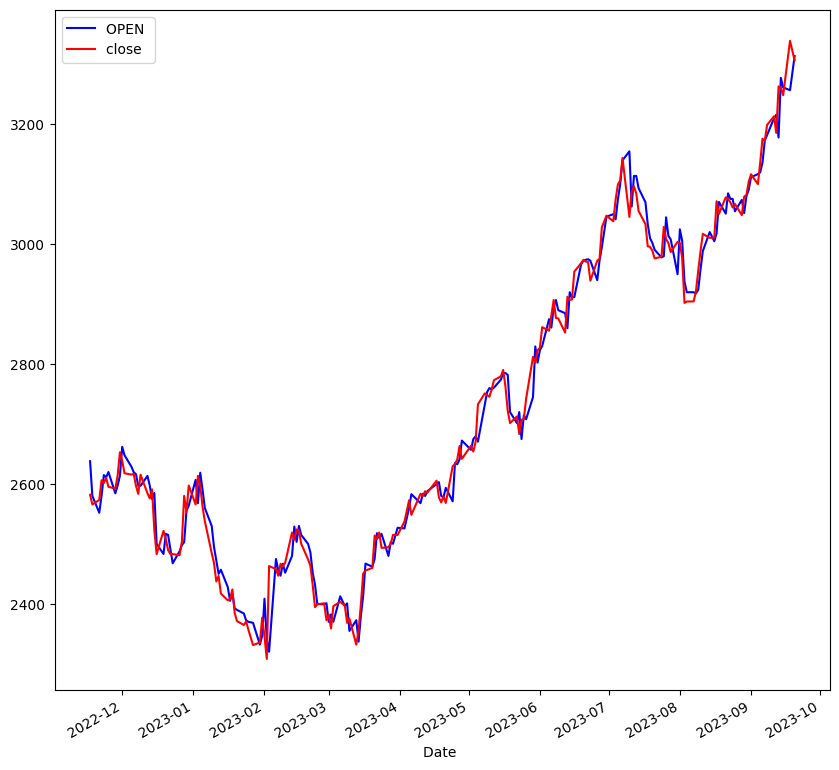

In [ ]:
titan_train.plot(y = ["OPEN ", "close "], kind="line", figsize=(10, 10), color = ["blue", "red"])

In [ ]:
del x_train
del x_val

x_train = titan_train[['OPEN ', 'VOLUME ', 'close ', 'HIGH ', 'LOW ', 'ltp ']]
x_val = titan_val[['OPEN ', 'VOLUME ', 'close ', 'HIGH ', 'LOW ', 'ltp ']]

x_train['Interaction_Feature'] = x_train['OPEN '] * x_train['VOLUME ']

x_train['Open_Lag1'] = x_train['OPEN '].shift(1)
x_train['Open_Lag2'] = x_train['OPEN '].shift(2)
x_train['Open_Lag3'] = x_train['OPEN '].shift(3)
x_train['Open_Lag4'] = x_train['OPEN '].shift(4)

x_train['Volume_Lag1'] = x_train['VOLUME '].shift(1)
x_train['Volume_Lag2'] = x_train['VOLUME '].shift(2)
x_train['Volume_Lag3'] = x_train['VOLUME '].shift(3)
x_train['Volume_Lag4'] = x_train['VOLUME '].shift(3)

x_train['Open_ma5'] = x_train['OPEN '].rolling(5).mean()
x_train['Open_ma8'] = x_train['OPEN '].rolling(8).mean()
x_train['Open_ma10'] = x_train['OPEN '].rolling(10).mean()

x_train['Volume_ma5'] = x_train['VOLUME '].rolling(5).mean()
x_train['Volume_ma8'] = x_train['VOLUME '].rolling(8).mean()
x_train['Volume_ma10'] = x_train['VOLUME '].rolling(10).mean()

<ipython-input-47-785ab186049c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Interaction_Feature'] = x_train['OPEN '] * x_train['VOLUME ']
<ipython-input-47-785ab186049c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Open_Lag1'] = x_train['OPEN '].shift(1)
<ipython-input-47-785ab186049c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [ ]:
x_val['Interaction_Feature'] = x_val['OPEN '] * x_val['VOLUME ']

x_val['Open_Lag1'] = x_val['OPEN '].shift(1)
x_val['Open_Lag2'] = x_val['OPEN '].shift(2)
x_val['Open_Lag3'] = x_val['OPEN '].shift(3)
x_val['Open_Lag4'] = x_val['OPEN '].shift(4)

x_val['Volume_Lag1'] = x_val['VOLUME '].shift(1)
x_val['Volume_Lag2'] = x_val['VOLUME '].shift(2)
x_val['Volume_Lag3'] = x_val['VOLUME '].shift(3)
x_val['Volume_Lag4'] = x_val['VOLUME '].shift(3)

x_val['Open_ma5'] = x_val['OPEN '].rolling(5).mean()
x_val['Open_ma8'] = x_val['OPEN '].rolling(8).mean()
x_val['Open_ma10'] = x_val['OPEN '].rolling(10).mean()

x_val['Volume_ma5'] = x_val['VOLUME '].rolling(5).mean()
x_val['Volume_ma8'] = x_val['VOLUME '].rolling(8).mean()
x_val['Volume_ma10'] = x_val['VOLUME '].rolling(10).mean()

<ipython-input-48-08a16567eb51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Interaction_Feature'] = x_val['OPEN '] * x_val['VOLUME ']
<ipython-input-48-08a16567eb51>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Open_Lag1'] = x_val['OPEN '].shift(1)
<ipython-input-48-08a16567eb51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
x_train = x_train.dropna()
x_train

,OPEN,VOLUME,close,HIGH,LOW,ltp,Interaction_Feature,Open_Lag1,Open_Lag2,Open_Lag3,...,Volume_Lag1,Volume_Lag2,Volume_Lag3,Volume_Lag4,Open_ma5,Open_ma8,Open_ma10,Volume_ma5,Volume_ma8,Volume_ma10
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-30,2613.75,1569918.0,2653.00,2665.00,2604.20,2657.25,4.103373e+09,2597.15,2584.40,2620.00,...,866621.0,665149.0,633047.0,633047.0,2605.26,2596.65625,2599.125,897360.2,877598.000,932518.2
2022-12-01,2662.00,539844.0,2638.70,2665.00,2630.00,2636.95,1.437065e+09,2613.75,2597.15,2584.40,...,1569918.0,866621.0,665149.0,665149.0,2615.46,2610.40625,2601.525,854915.8,866448.500,859937.9
2022-12-02,2648.00,731396.0,2617.90,2651.40,2605.00,2618.00,1.936737e+09,2662.00,2613.75,2597.15,...,539844.0,1569918.0,866621.0,866621.0,2621.06,2618.90625,2608.325,874585.6,843864.250,829202.4
2022-12-05,2629.00,747114.0,2615.65,2629.95,2589.25,2614.80,1.964163e+09,2648.00,2662.00,2613.75,...,731396.0,539844.0,1569918.0,1569918.0,2629.98,2620.66250,2616.025,890978.6,813144.375,841009.8
2022-12-06,2619.80,706596.0,2617.00,2624.00,2591.30,2611.10,1.851140e+09,2629.00,2648.00,2662.00,...,747114.0,731396.0,539844.0,539844.0,2634.51,2621.76250,2620.005,858973.6,807460.625,820462.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,3178.05,1370306.0,3263.20,3270.00,3178.05,3261.00,4.354901e+09,3216.05,3209.95,3182.00,...,591509.0,544452.0,700158.0,700158.0,3191.81,3166.51875,3153.495,802344.0,804485.750,828012.3
2023-09-14,3277.55,1264935.0,3261.35,3302.45,3240.00,3258.00,4.145888e+09,3178.05,3216.05,3209.95,...,1370306.0,591509.0,544452.0,544452.0,3212.72,3186.59375,3172.165,894272.0,895126.000,812456.0
2023-09-15,3261.60,1397407.0,3248.60,3264.00,3239.00,3245.00,4.557783e+09,3277.55,3178.05,3216.05,...,1264935.0,1370306.0,591509.0,591509.0,3228.64,3204.29375,3187.130,1033721.8,979652.000,909822.8


In [ ]:
x_val = x_val.dropna()
x_val

,OPEN,VOLUME,close,HIGH,LOW,ltp,Interaction_Feature,Open_Lag1,Open_Lag2,Open_Lag3,...,Volume_Lag1,Volume_Lag2,Volume_Lag3,Volume_Lag4,Open_ma5,Open_ma8,Open_ma10,Volume_ma5,Volume_ma8,Volume_ma10
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-06,3230.00,1102120.0,3309.75,3319.800000,3221.10000,3305.20,3.559848e+09,3173.90,3186.00,3148.80,...,1109881.0,486969.0,1007308.0,1007308.0,3179.75,3207.13125,3223.035,880768.40,1017155.500,977981.00
2023-10-09,3294.70,822467.0,3267.50,3296.000000,3249.05000,3265.00,2.709782e+09,3230.00,3173.90,3186.00,...,1102120.0,1109881.0,486969.0,486969.0,3206.68,3207.21875,3222.625,905749.00,988110.500,958322.60
2023-10-10,3295.00,633934.0,3269.20,3299.200000,3259.30000,3265.95,2.088813e+09,3294.70,3230.00,3173.90,...,822467.0,1102120.0,1109881.0,1109881.0,3235.92,3213.24375,3224.675,831074.20,884328.250,959364.50
2023-10-11,3289.70,546575.0,3280.50,3296.000000,3264.00000,3282.00,1.798068e+09,3295.00,3294.70,3230.00,...,633934.0,822467.0,1102120.0,1102120.0,3256.66,3222.26875,3224.245,842995.40,800852.250,908539.30
2023-10-12,3292.00,429096.0,3285.00,3295.050000,3262.60000,3288.00,1.412584e+09,3289.70,3295.00,3294.70,...,546575.0,633934.0,822467.0,822467.0,3280.28,3238.76250,3228.765,706838.40,767293.750,805029.70
2023-10-13,3285.00,920545.0,3283.75,3307.000000,3266.55000,3284.00,3.023990e+09,3292.00,3289.70,3295.00,...,429096.0,546575.0,633934.0,633934.0,3291.28,3255.78750,3235.515,670523.40,756448.375,775645.90
2023-10-16,3284.00,778014.0,3301.40,3329.000000,3275.00000,3303.50,2.554998e+09,3285.00,3292.00,3289.70,...,920545.0,429096.0,546575.0,546575.0,3289.14,3268.03750,3247.910,661632.80,792829.000,783690.90
2023-10-17,3317.95,584625.0,3308.45,3328.450000,3304.10000,3312.00,1.939757e+09,3284.00,3285.00,3292.00,...,778014.0,920545.0,429096.0,429096.0,3293.73,3286.04375,3264.825,651771.00,727172.000,741422.60
2023-10-18,3309.20,324535.0,3282.75,3324.150000,3277.50000,3283.50,1.073951e+09,3317.95,3284.00,3285.00,...,584625.0,778014.0,920545.0,920545.0,3297.63,3295.94375,3277.145,607363.00,629973.875,725179.20


In [ ]:
exog = sm.add_constant(x_train[['OPEN ', 'VOLUME ', 'HIGH ', 'LOW ', 'Interaction_Feature', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Open_ma5', 'Open_ma8', 'Open_ma10', 'Volume_ma5', 'Volume_ma8', 'Volume_ma10']])

titan_sarimax_model = SARIMAX(endog = x_train['close '], exog=exog, order=(5, 1, 2), seasonal_order=(1, 1, 1, 12))
titan_sarimax_model_fit = titan_sarimax_model.fit(disp = False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

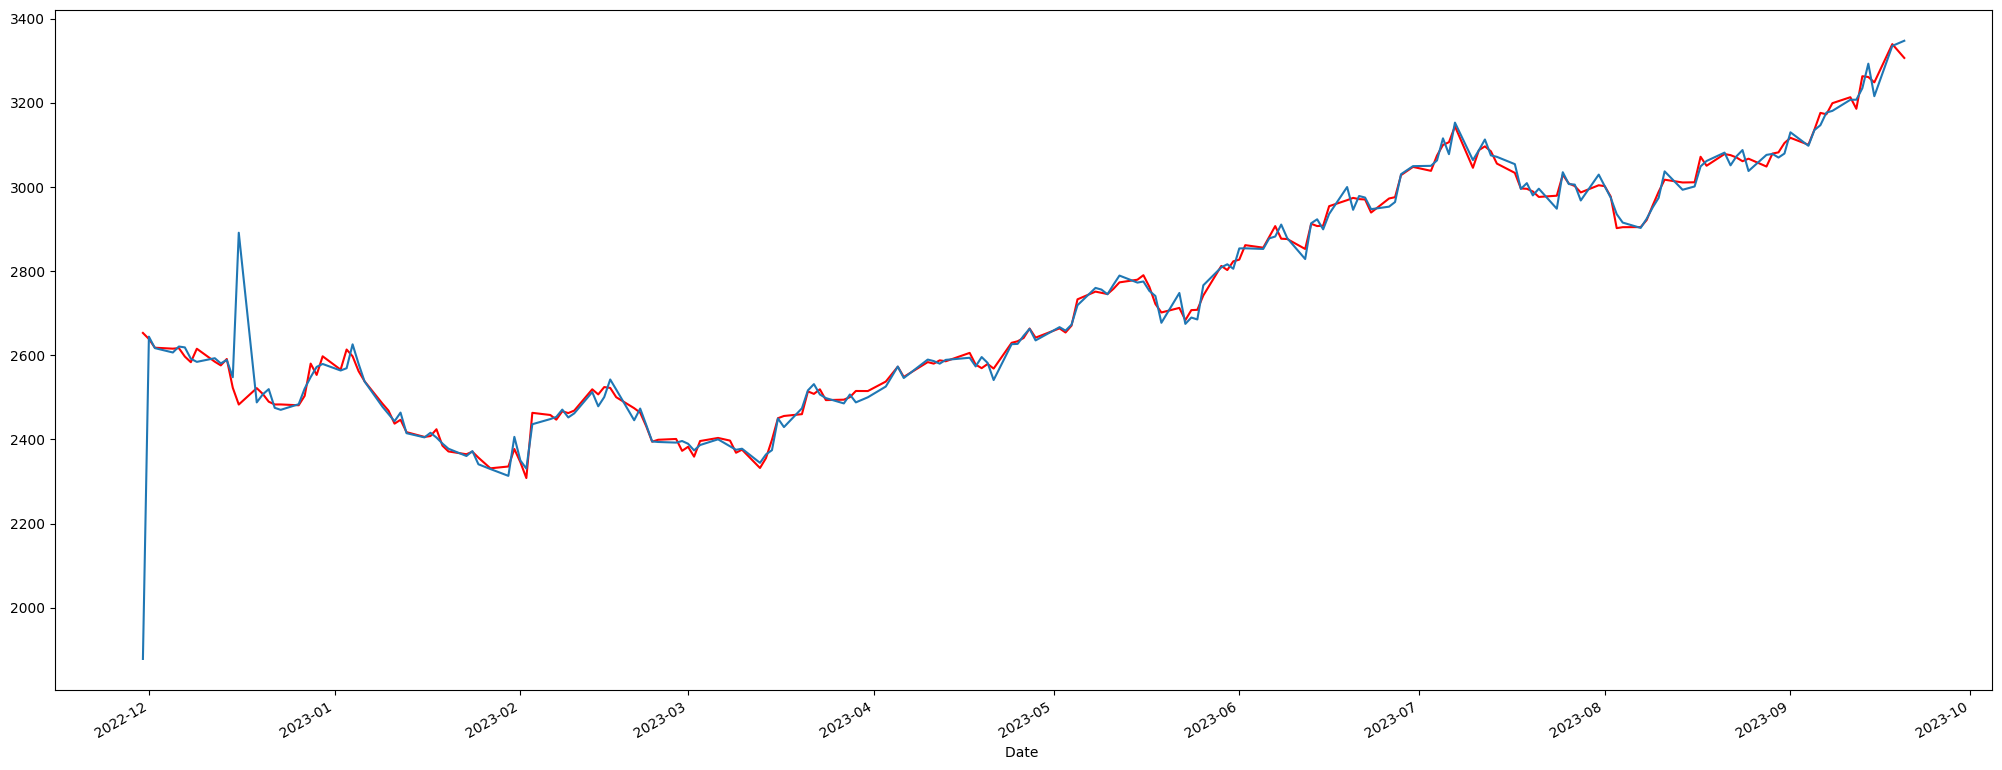

In [ ]:
import matplotlib.pyplot as plt

x_train['close '].plot(figsize=(25,10), color = "red")
titan_sarimax_model_fit.fittedvalues.plot()
plt.show()

In [ ]:
titan_sarima_predict = titan_sarimax_model_fit.predict(start = len(x_train), end = len(x_train) + len(x_val)-1, exog = sm.add_constant(x_val[['OPEN ', 'VOLUME ', 'HIGH ', 'LOW ', 'Interaction_Feature', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Open_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Volume_Lag1', 'Open_ma5', 'Open_ma8', 'Open_ma10', 'Volume_ma5', 'Volume_ma8', 'Volume_ma10']]))
x_val['close_predicted'] = titan_sarima_predict.values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date '>

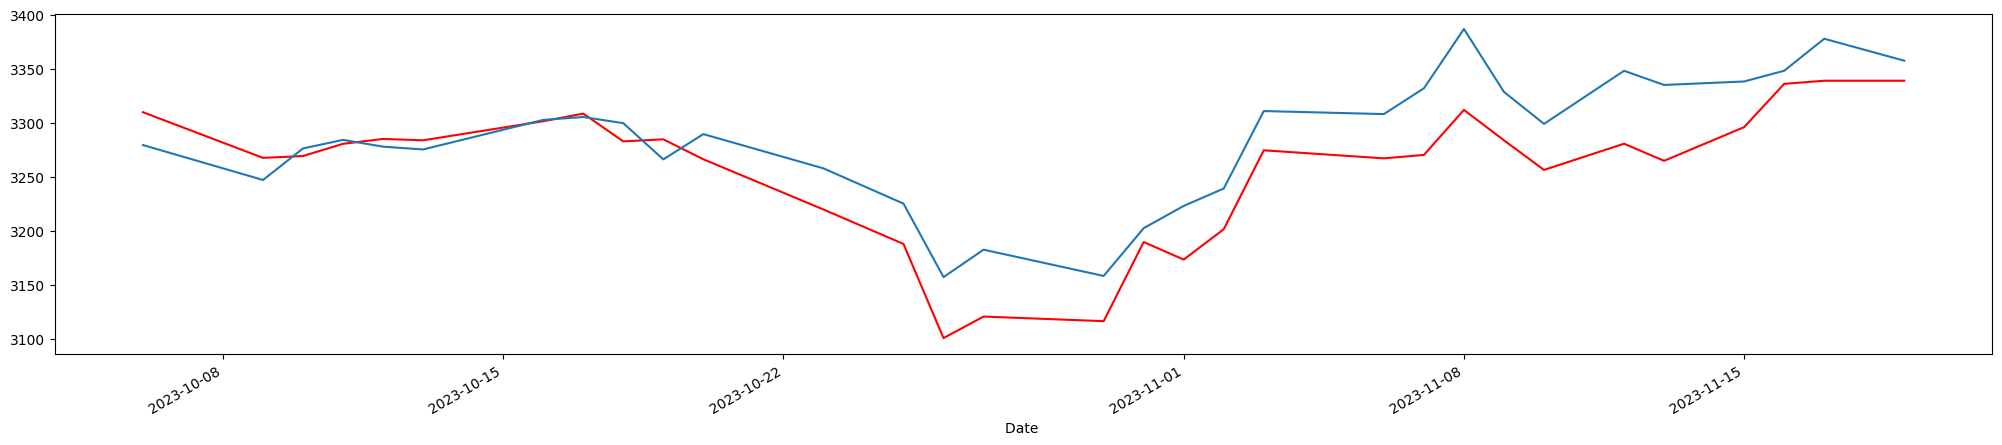

In [ ]:
x_val['close '].plot(figsize=(25,5), color = "red")
x_val['close_predicted'].plot(figsize=(25,5))

In [ ]:
smape = np.mean(np.abs(x_val['close_predicted'] - x_val['close ']) / (np.abs(x_val['close_predicted']) + np.abs(x_val['close '])))
smape

0.005071174109465572

In [ ]:
titan_pred = x_val['close_predicted'][30]

# Final Output

We will now save the predictions in an Excel sheet.

In [ ]:
result = {'Ticker': ['APOLLOHOSP', 'TITAN', 'ASIANPAINT'],
          'Prediction': [apollo_pred, titan_pred, asian_pred]}

result_df = pd.DataFrame(result)
result_df

,Ticker,Prediction
0,APOLLOHOSP,5509.261385
1,TITAN,3357.376620
2,ASIANPAINT,3155.925572


In [ ]:
result_df.to_excel('prediction.xlsx', header=False, index=False)